<a href="https://colab.research.google.com/github/RavinduP/Product_Success/blob/Recommendation_System/Final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing values before preprocessing:
 Series([], dtype: int64)

Best Hyperparameters:
{'class_weight': 'balanced', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 100}

Model Performance Metrics:

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.95      0.83        20
           1       1.00      1.00      1.00        19
           2       0.93      0.65      0.76        20
           3       1.00      1.00      1.00        19

    accuracy                           0.90        78
   macro avg       0.91      0.90      0.90        78
weighted avg       0.91      0.90      0.90        78


Confusion Matrix:
[[19  0  1  0]
 [ 0 19  0  0]
 [ 7  0 13  0]
 [ 0  0  0 19]]

Predictions with Confidence Threshold:
Number of predictions below 70.0% confidence: 49

Top 10 Feature Importance with Standard Deviation:
                      Feature  Importance       Std
10  Influencer C

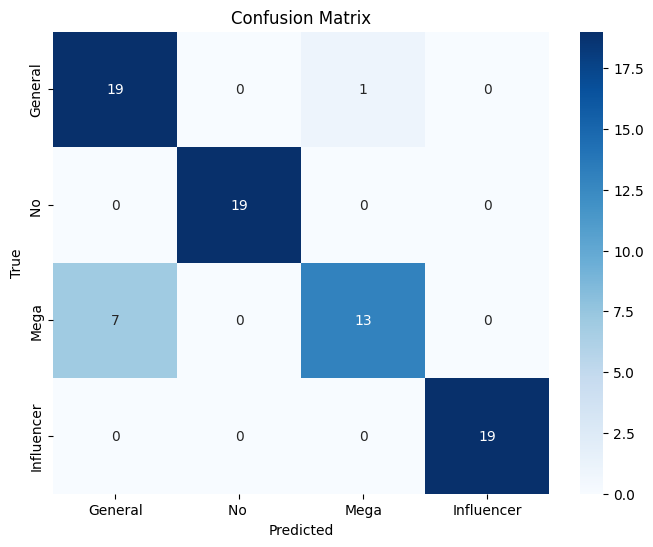

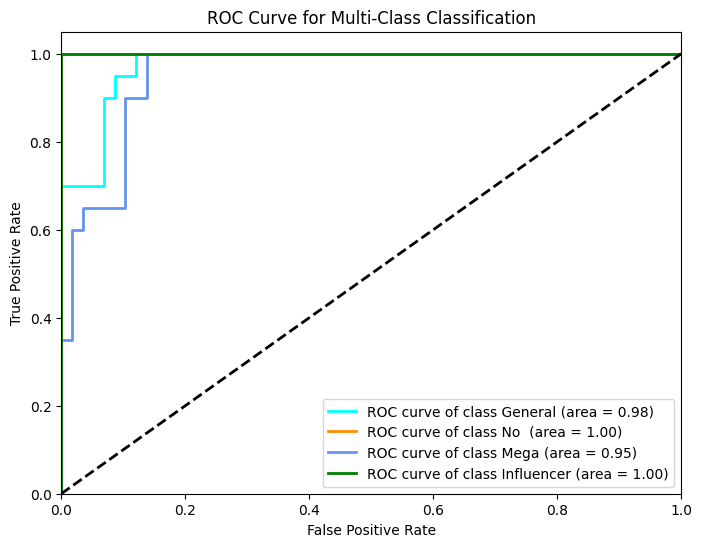

<ipython-input-2-01d465f7bc28>:232: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")


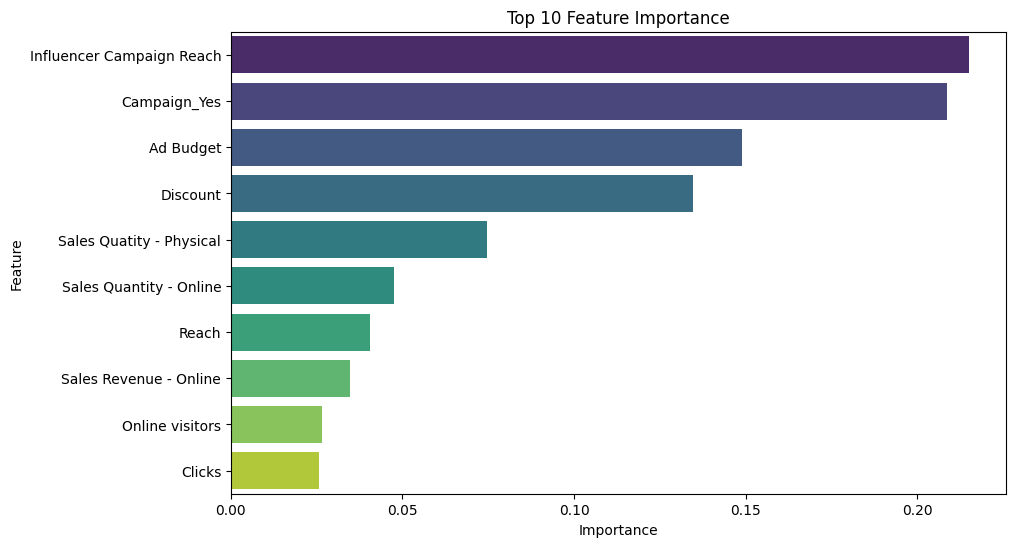

<ipython-input-2-01d465f7bc28>:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_before, palette="Set2")
<ipython-input-2-01d465f7bc28>:249: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_after, palette="Set2")


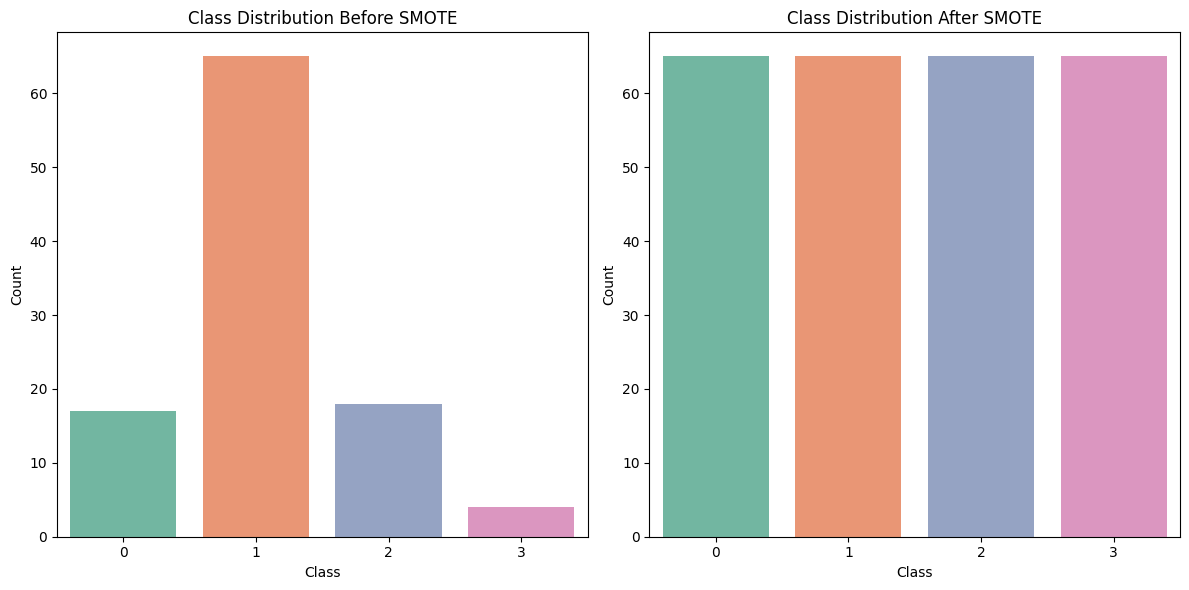

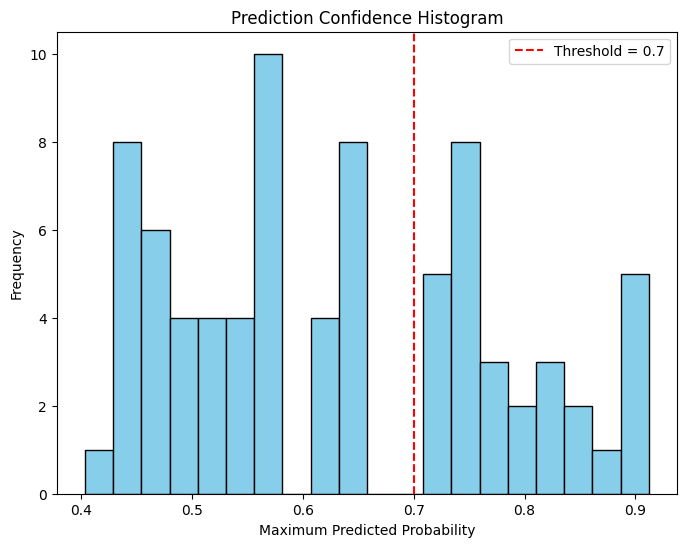

In [2]:
#final with visualization
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# Load dataset
data_path = 'final_data.csv'
data = pd.read_csv(data_path)

# Clean numeric columns
def clean_numeric_column(column):
    return pd.to_numeric(column.replace({',': '', '%': ''}, regex=True), errors='coerce')

numeric_columns = [
    "Sales Revenue - Physical", "Online visitors", "Page Views", "Sales Revenue - Online",
    "Conversion", "Reach", "Impressions", "Clicks", "Influencer Campaign Reach",
    "Ad Budget", "Discount"
]

for col in numeric_columns:
    if col in data.columns:
        data[col] = clean_numeric_column(data[col])

# Fix column name issue
data.rename(columns={'Discount ': 'Discount'}, inplace=True)

# Handle missing values
for col in numeric_columns:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].median())

data.dropna(subset=["Ad Type", "Campaign Type"], inplace=True)

# Drop unnecessary features
features_to_drop = [
    'Year',
    'Conversion',
    'Ad Type'
]

data_reduced = data.drop(features_to_drop, axis=1)

# Encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_columns = ["Campaign"]
encoded_cats = encoder.fit_transform(data_reduced[categorical_columns])
encoded_cat_columns = encoder.get_feature_names_out(categorical_columns)
data_reduced = data_reduced.drop(categorical_columns, axis=1)
data_reduced[encoded_cat_columns] = encoded_cats

# Convert 'Month' to numeric and handle missing values
data_reduced['Month'] = pd.to_numeric(data_reduced['Month'], errors='coerce')

# Handle missing values in 'Month' column
if data_reduced['Month'].mode().empty:
    data_reduced['Month'] = data_reduced['Month'].fillna(1)
else:
    data_reduced['Month'] = data_reduced['Month'].fillna(data_reduced['Month'].mode().iloc[0])

# Define features and target
X = data_reduced.drop(["Campaign Type"], axis=1)
y = data_reduced["Campaign Type"]

# Encode target variable
y_encoded = pd.factorize(y)[0]

# Check for missing values in X
missing_values = X.isna().sum()
print("Missing values before preprocessing:\n", missing_values[missing_values > 0])

# Fill missing values with column medians
X = X.fillna(X.median(numeric_only=True))

# Drop any remaining rows with missing values
X.dropna(inplace=True)
y_encoded = y_encoded[:len(X)]

# Add feature scaling
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# More aggressive SMOTE approach
# Oversample all minority classes to match the majority class size
n_samples_majority = Counter(y_encoded).most_common(1)[0][1]
sampling_strategy = {label: n_samples_majority for label in Counter(y_encoded).keys()}

smote = SMOTE(
    sampling_strategy=sampling_strategy,
    random_state=42,
    k_neighbors=min(5, min(Counter(y_encoded).values()) - 1)
)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.3,
    random_state=42,
    stratify=y_resampled
)

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [2, 3],
    'min_samples_split': [15, 20],
    'min_samples_leaf': [8, 10],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

# Use StratifiedKFold with fewer folds
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid search with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring=['accuracy', 'f1_macro', 'balanced_accuracy'],
    refit='balanced_accuracy',
    n_jobs=-1
)

# Train model
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_

# Make predictions with higher confidence threshold
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Increase confidence threshold
confidence_threshold = 0.7
y_pred_with_threshold = np.array([
    pred if max(proba) >= confidence_threshold else -1
    for pred, proba in zip(y_pred, y_pred_proba)
])

# Calculate and print results
print("\nBest Hyperparameters:")
print(grid_search.best_params_)

print("\nModel Performance Metrics:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nPredictions with Confidence Threshold:")
print(f"Number of predictions below {confidence_threshold*100}% confidence: "
      f"{sum(y_pred_with_threshold == -1)}")

# Calculate feature importance with uncertainty
importances = best_model.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in best_model.estimators_
], axis=0)

feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances,
    "Std": std
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Feature Importance with Standard Deviation:")
print(feature_importance_df.head(10))

# Print campaign type mapping
print("\nCampaign Type Mapping:")
print(dict(enumerate(data_reduced["Campaign Type"].unique())))

# Perform cross-validation on the best model
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='balanced_accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Visualization Functions

# 1. Confusion Matrix Heatmap
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# 2. ROC Curve for Multi-Class Classification
def plot_roc_curve(y_true, y_pred_proba, class_names):
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_true_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Multi-Class Classification")
    plt.legend(loc="lower right")
    plt.show()

# 3. Feature Importance Bar Plot
def plot_feature_importance(feature_importance_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")
    plt.title("Top 10 Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# 4. Class Distribution Before and After SMOTE
def plot_class_distribution(y_before, y_after, title_before, title_after):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.countplot(x=y_before, palette="Set2")
    plt.title(title_before)
    plt.xlabel("Class")
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    sns.countplot(x=y_after, palette="Set2")
    plt.title(title_after)
    plt.xlabel("Class")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

# 5. Prediction Confidence Histogram
def plot_confidence_histogram(y_pred_proba, confidence_threshold):
    max_proba = np.max(y_pred_proba, axis=1)
    plt.figure(figsize=(8, 6))
    plt.hist(max_proba, bins=20, color="skyblue", edgecolor="black")
    plt.axvline(x=confidence_threshold, color="red", linestyle="--", label=f"Threshold = {confidence_threshold}")
    plt.title("Prediction Confidence Histogram")
    plt.xlabel("Maximum Predicted Probability")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Plot Confusion Matrix
class_names = list(data_reduced["Campaign Type"].unique())
plot_confusion_matrix(y_test, y_pred, class_names)

# Plot ROC Curve
plot_roc_curve(y_test, y_pred_proba, class_names)

# Plot Feature Importance
plot_feature_importance(feature_importance_df)

# Plot Class Distribution Before and After SMOTE
plot_class_distribution(y_encoded, y_resampled, "Class Distribution Before SMOTE", "Class Distribution After SMOTE")

# Plot Prediction Confidence Histogram
plot_confidence_histogram(y_pred_proba, confidence_threshold)